# Capstone Project - The Battle of the Neighborhoods (Week 2)  
### Applied Data Science Capstone by IBM/Coursera

## Introduction: Business Problem

California is the largest sub-national economy in the world, with 39.5 million residents across a total area of about 163,696 square miles (423,970 km2). As California is so big, people‘s income and consumption level could diverse from city to city. When we think of it by the investor, they prefer the city where the type of business they want to install is less intense, while the consumer's  income match the product price. If we think of the residents, they would like to choose those city with higher GDP per capita, which means higher income, and variety of shop venues. 

## Data

* US goverment reported GDP per capita of county, and I get the data from this link: https://www.bea.gov/system/files/2019-11/lapi1119.xlsx. I cleaned the data and reduced it to California where I want to analysis.
* I used **Forsquare API** to get the most common venues of given county of California.
* I used google search to get the center coordinates of each county
* geojson from https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/california-counties.geojson

In [1]:
# get the gdp data
# !wget -O lapi1119.xlsx https://www.bea.gov/system/files/2019-11/lapi1119.xlsx

In [27]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import folium
import requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [3]:
df = pd.read_excel("lapi1119.xlsx",skiprows=3)
df.head()

,Unnamed: 0,2016,2017,2018,2018.1,2017.1,2018.2,2018.3
0,United States,49870.0,51885.0,54446.0,--,4.0,4.9,--
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,39224.0,40467.0,42238.0,--,3.2,4.4,--
3,Autauga,39561.0,40450.0,41618.0,10,2.2,2.9,61
4,Baldwin,42907.0,43989.0,45596.0,4,2.5,3.7,55


In [4]:
df.rename(columns={df.columns[0]:'county',2018:'GDP_per_capita'},inplace=True)
df_california = df[197:255][['county','GDP_per_capita']].reset_index(drop=True)
df_california['county'] = df_california['county'].astype(str)
df_california


,county,GDP_per_capita
0,Alameda,76644.0
1,Alpine,73307.0
2,Amador,44793.0
3,Butte,44346.0
4,Calaveras,49893.0
5,Colusa,49094.0
6,Contra Costa,82506.0
7,Del Norte,37268.0
8,El Dorado,67464.0
9,Fresno,43084.0


combine it with coordinates

In [5]:
df_coor = pd.read_csv('coordinates_california.csv')
df_coor['county'] = df_coor['county'].astype(str)
df_california = pd.merge(df_california,df_coor,on = 'county')
df_california

,county,GDP_per_capita,lat,lon
0,Alameda,76644.0,37.7799,-122.2822
1,Alpine,73307.0,32.8351,-116.7664
2,Amador,44793.0,38.3489,-120.7741
3,Butte,44346.0,39.6254,-121.5370
4,Calaveras,49893.0,38.1960,-120.6805
5,Colusa,49094.0,39.2143,-122.0094
6,Contra Costa,82506.0,37.8534,-121.9018
7,Del Norte,37268.0,41.7076,-123.9660
8,El Dorado,67464.0,38.7426,-120.4358
9,Fresno,43084.0,36.7378,-119.7871


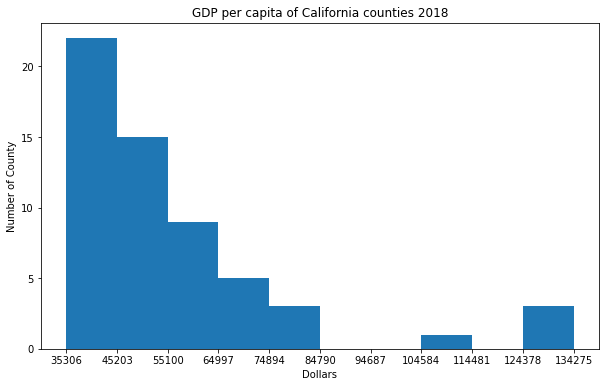

In [127]:
count, bin_edges = np.histogram(df_california['GDP_per_capita'])
df_california['GDP_per_capita'].plot(kind='hist', figsize=(10, 6), xticks=bin_edges)

plt.title('GDP per capita of California counties 2018') # add a title to the histogram
plt.ylabel('Number of County') # add y-label
plt.xlabel('Dollars') # add x-label

plt.show()

We can define 7 range

In [128]:
new_bin = bin_edges[0:6].tolist()
new_bin.append(float(bin_edges[8]))
new_bin.append(float(bin_edges[-1]))
new_bin

[35306.0, 45202.9, 55099.8, 64996.7, 74893.6, 84790.5, 114481.2, 134275.0]

let's visulize it

In [135]:
california_geo = r'california-geo.json' # geojson file
california_map = folium.Map(location=[36.7783, -119.4179], zoom_start=6.3)

california_map.choropleth(
    geo_data=california_geo,
    data=df_california,
    columns=['county', 'GDP_per_capita'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='GDP per capita in California',
    bins = new_bin
)
california_map

Use **Foursquare** to get venues data

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['county', 
                  'county Latitude', 
                  'county Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
LIMIT = 500
CLIENT_ID = '5AAFYZ5TDM4VGG0XIAAZ334HVYT05ZHFAF1QHVSXHWGRMW02' # your Foursquare ID
CLIENT_SECRET = 'RPQDU5EQKF055NSGZEJNWU0FK3EEBAEVJBNFWC0CILSRYEJR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [9]:
california_venues = getNearbyVenues(names=df_california['county'],
                                   latitudes=df_california['lat'],
                                   longitudes=df_california['lon']
                                  )

Alameda
Alpine
Amador
Butte
Calaveras
Colusa
Contra Costa
Del Norte
El Dorado
Fresno
Glenn
Humboldt
Imperial
Inyo
Kern
Kings
Lake
Lassen
Los Angeles
Madera
Marin
Mariposa
Mendocino
Merced
Modoc
Mono
Monterey
Napa
Nevada
Orange
Placer
Plumas
Riverside
Sacramento
San Benito
San Bernardino
San Diego
San Francisco
San Joaquin
San Luis Obispo
San Mateo
Santa Barbara
Santa Clara
Santa Cruz
Shasta
Sierra
Siskiyou
Solano
Sonoma
Stanislaus
Sutter
Tehama
Trinity
Tulare
Tuolumne
Ventura
Yolo
Yuba


In [10]:
print(california_venues.shape)
california_venues.head()

(3101, 7)


,county,county Latitude,county Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alameda,37.7799,-122.2822,In-N-Out Burger,37.783816,-122.277145,Fast Food Restaurant
1,Alameda,37.7799,-122.2822,Peet's Coffee & Tea,37.778452,-122.276803,Coffee Shop
2,Alameda,37.7799,-122.2822,Almanac Beer Co. Barrel House & Taproom,37.783144,-122.298627,Brewery
3,Alameda,37.7799,-122.2822,Jack London Square,37.794942,-122.276474,Plaza
4,Alameda,37.7799,-122.2822,Crab Cove,37.769109,-122.277731,Beach


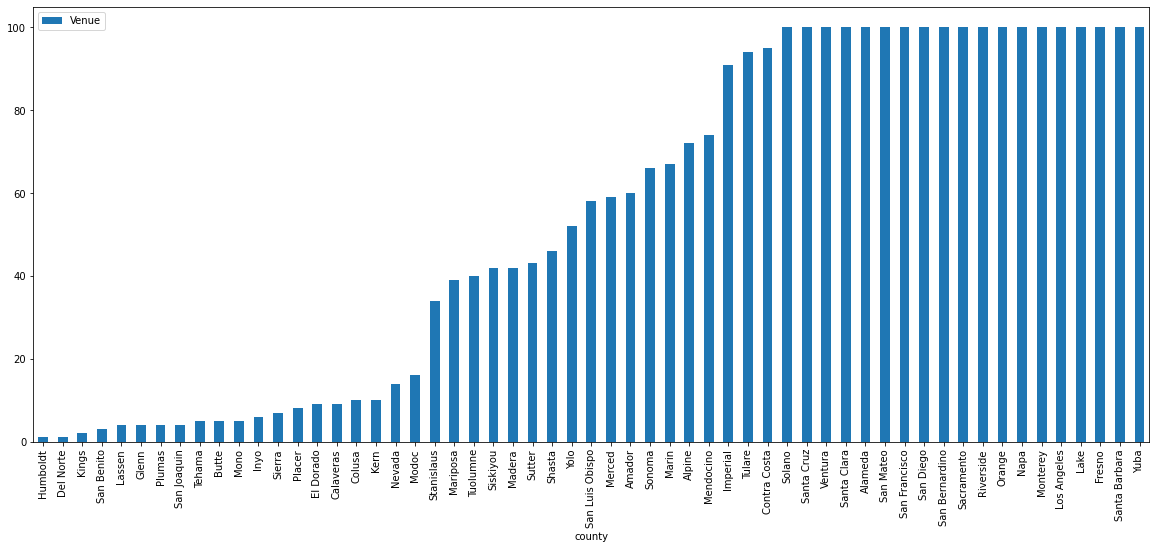

In [20]:
california_venues.groupby('county').count().sort_values(by='Venue').plot.bar(y='Venue',figsize=(20,8))

In [43]:
california_venues.groupby('county').count()

,county Latitude,county Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
county,,,,,,
Alameda,100,100,100,100,100,100
Alpine,72,72,72,72,72,72
Amador,60,60,60,60,60,60
Butte,5,5,5,5,5,5
Calaveras,9,9,9,9,9,9
Colusa,10,10,10,10,10,10
Contra Costa,95,95,95,95,95,95
Del Norte,1,1,1,1,1,1
El Dorado,9,9,9,9,9,9


In [ ]:
Analyze the venues

In [21]:
california_onehot = pd.get_dummies(california_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
california_onehot['county'] = california_venues['county'] 

# move neighborhood column to the first column
fixed_columns = [california_onehot.columns[-1]] + list(california_onehot.columns[:-1])
california_onehot = california_onehot[fixed_columns]

california_onehot.head()

,county,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Gym,College Residence Hall,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Intersection,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Truck Stop,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Par

In [23]:
california_onehot.shape

(3101, 301)

Next, let's group rows by county and by taking the mean of the frequency of occurrence of each category

In [24]:
california_grouped = california_onehot.groupby('county').mean().reset_index()
california_grouped

,county,ATM,Accessories Store,Adult Boutique,Airport,American Restaurant,Amphitheater,Aquarium,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,Bay,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Trail,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Burger Joint,Burmese Restaurant,Burrito Place,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,City,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Basketball Court,College Gym,College Residence Hall,Comic Shop,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Courthouse,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Drugstore,Electronics Store,Ethiopian Restaurant,Event Space,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Forest,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hot Dog Joint,Hot Spring,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Inn,Insurance Office,Intersection,Island,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Library,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Mountain,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,National Park,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Outlet Mall,Outlet Store,Paintball Field,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Print Shop,Pub,RV Park,Racetrack,Rafting,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Reservoir,Resort,Rest Area,Restaurant,River,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Smoothie Shop,Snack Place,Soccer Stadium,Social Club,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,State / Provincial Park,Steakhouse,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Thrift / Vintage Store,Tiki Bar,Tourist Information Center,Toy / Game Store,Trail,Train Station,Tree,Truck Stop,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Water Par

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [138]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['county']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
california_venues_sorted = pd.DataFrame(columns=columns)
california_venues_sorted['county'] = california_grouped['county']

for ind in np.arange(california_grouped.shape[0]):
    california_venues_sorted.iloc[ind, 1:] = return_most_common_venues(california_grouped.iloc[ind, :], num_top_venues)

california_venues_sorted.head()

,county,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Brewery,Coffee Shop,Bakery,Café,Music Venue,Ice Cream Shop,American Restaurant,Park,Pizza Place,Beer Garden
1,Alpine,Mexican Restaurant,Casino,Clothing Store,American Restaurant,Shoe Store,Café,Italian Restaurant,BBQ Joint,Reservoir,Sandwich Place
2,Amador,Hotel,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Business Service,Italian Restaurant,Market
3,Butte,Snack Place,Zoo,Nature Preserve,Bus Stop,Waterfall,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Calaveras,Sandwich Place,RV Park,Hotel,Airport,Construction & Landscaping,Bank,Mexican Restaurant,Diner,Zoo Exhibit,Filipino Restaurant


Run k-means to cluster the county into clusters.

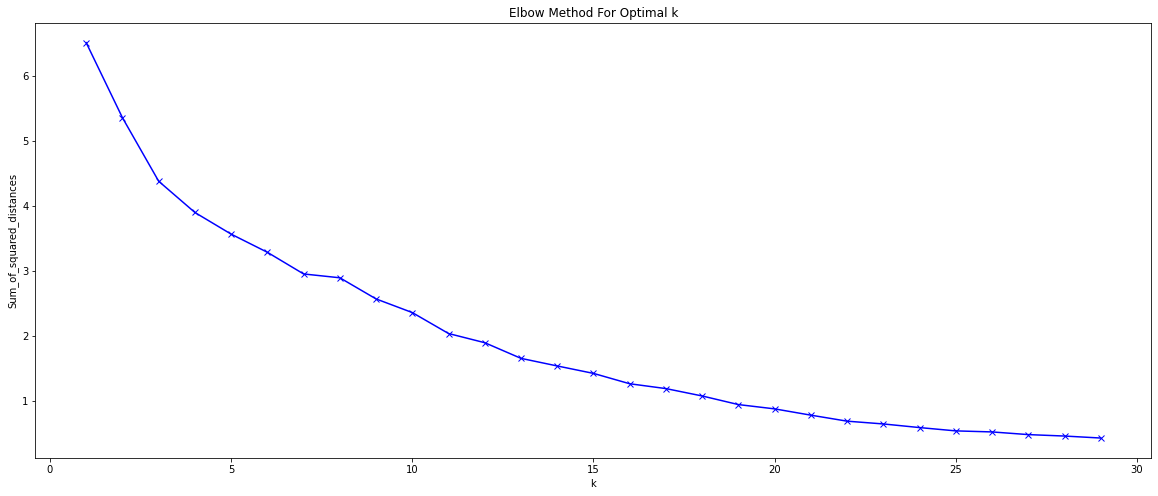

In [154]:
california_grouped_clustering = california_grouped.drop('county', 1)

# run k-means clustering
Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(california_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.rcParams["figure.figsize"]=(20,8)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In the plot above the elbow is at k=7 indicating the optimal k for this dataset is 7

In [140]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(california_grouped_clustering)

# add clustering labels
california_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
california_venues_sorted['Cluster Labels'] = california_venues_sorted['Cluster Labels'].astype(int)

california_merged = df_california.drop(52)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
california_merged = california_merged.join(california_venues_sorted.set_index('county'), on='county')

california_merged.head() # check the last columns!


,county,GDP_per_capita,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,76644.0,37.7799,-122.2822,6,Brewery,Coffee Shop,Bakery,Café,Music Venue,Ice Cream Shop,American Restaurant,Park,Pizza Place,Beer Garden
1,Alpine,73307.0,32.8351,-116.7664,6,Mexican Restaurant,Casino,Clothing Store,American Restaurant,Shoe Store,Café,Italian Restaurant,BBQ Joint,Reservoir,Sandwich Place
2,Amador,44793.0,38.3489,-120.7741,6,Hotel,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Business Service,Italian Restaurant,Market
3,Butte,44346.0,39.6254,-121.5370,0,Snack Place,Zoo,Nature Preserve,Bus Stop,Waterfall,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Calaveras,49893.0,38.1960,-120.6805,6,Sandwich Place,RV Park,Hotel,Airport,Construction & Landscaping,Bank,Mexican Restaurant,Diner,Zoo Exhibit,Filipino Restaurant


Visualize the clusters

In [130]:
x = np.arange(7)
ys = [i + x + (i*x)**2 for i in range(7)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(california_merged['lat'], california_merged['lon'], california_merged['county'], california_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(california_map)
       
california_map

In [98]:
california_merged.groupby(['Cluster Labels',california_merged.columns[5]]).count()[['county']]

county
Cluster Labels 1st Most Common Venue             
0              Forest                           1
               Historic Site                    1
               National Park                    1
               Park                             1
               River                            1
               Snack Place                      1
               Trail                            1
1              Airport                          1
2              Restaurant                       1
3              Farm                             1
4              Campground                       2
5              Bar                              1
6              American Restaurant              1
               Beach                            4
               Bed & Breakfast                  1
               Brewery                          1
               Clothing Store                   2
               Coffee Shop                      4
               Construction & Landscaping       1
               Convenience Store                1
               Fast Food Restaurant             4
               Grocery Store                    3
               Gym                              1
               Hotel                            4
               Japanese Restaurant              1
               Mexican Restaurant               8
               Park                             1
               Pizza Place                      1
               Sandwich Place                   1
               Trail                            2
               Winery                           3

We can define the labels as below:
* Cluster 0 : “Torist county”
* Cluster 1 : “Transport County”
* Cluster 2 : “Catering County”
* Cluster 3 : “Agricultural County”
* Cluster 4 : “Camp County”
* Cluster 5 : “Beverage County”
* Cluster 6 : “Comprehensive County”

And according gdp per capita range, we can define the labels of consuming ability
* 35306.0-45202.9 Low-1 Level
* 45202.9-55099.8 Low-2 Level
* 55099.8-64996.7 Mid-1 Level
* 64996.7-74893.6 Mid-2 Level
* 74893.6-84790.5 Mid-3 Level
* 84790.5-114481.2 High-1 Level
* 114481.2-134275.0 High-2 Level


In [131]:
consuming_labels = ['Low-1 Level','Low-2 Level','Mid-1 Level','Mid-2 Level','Mid-3 Level','High-1 Level','High-2 Level']
california_final = california_merged
california_final['GDP_per_capita'] = pd.cut(california_final['GDP_per_capita'], new_bin, labels=consuming_labels, include_lowest=True )
california_final.head()

,county,GDP_per_capita,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Mid-3 Level,37.7799,-122.2822,6,Brewery,Coffee Shop,Bakery,Café,Music Venue,Ice Cream Shop,American Restaurant,Park,Pizza Place,Beer Garden
1,Alpine,Mid-2 Level,32.8351,-116.7664,6,Mexican Restaurant,Casino,Clothing Store,American Restaurant,Shoe Store,Café,Italian Restaurant,BBQ Joint,Reservoir,Sandwich Place
2,Amador,Low-1 Level,38.3489,-120.7741,6,Hotel,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Business Service,Italian Restaurant,Market
3,Butte,Low-1 Level,39.6254,-121.5370,0,Snack Place,Zoo,Nature Preserve,Bus Stop,Waterfall,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Calaveras,Low-2 Level,38.1960,-120.6805,6,Sandwich Place,RV Park,Hotel,Airport,Construction & Landscaping,Bank,Mexican Restaurant,Diner,Zoo Exhibit,Filipino Restaurant


In [134]:
cluster_labels = ['Torist county','Transport County','Catering County','Agricultural County','Camp County','Beverage County','Comprehensive County']
cluster_bin = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5]
california_final['Cluster Labels'] = pd.cut(california_final['Cluster Labels'], cluster_bin, labels=cluster_labels, include_lowest=True )
california_final.head()

,county,GDP_per_capita,lat,lon,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alameda,Mid-3 Level,37.7799,-122.2822,Comprehensive County,Brewery,Coffee Shop,Bakery,Café,Music Venue,Ice Cream Shop,American Restaurant,Park,Pizza Place,Beer Garden
1,Alpine,Mid-2 Level,32.8351,-116.7664,Comprehensive County,Mexican Restaurant,Casino,Clothing Store,American Restaurant,Shoe Store,Café,Italian Restaurant,BBQ Joint,Reservoir,Sandwich Place
2,Amador,Low-1 Level,38.3489,-120.7741,Comprehensive County,Hotel,Grocery Store,American Restaurant,Pizza Place,Coffee Shop,Sandwich Place,Pharmacy,Business Service,Italian Restaurant,Market
3,Butte,Low-1 Level,39.6254,-121.5370,Torist county,Snack Place,Zoo,Nature Preserve,Bus Stop,Waterfall,Zoo Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
4,Calaveras,Low-2 Level,38.1960,-120.6805,Comprehensive County,Sandwich Place,RV Park,Hotel,Airport,Construction & Landscaping,Bank,Mexican Restaurant,Diner,Zoo Exhibit,Filipino Restaurant


Final Visualization

In [143]:
x = np.arange(7)
ys = [i + x + (i*x)**2 for i in range(7)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, labeled_cluster, consuming_level in zip(california_merged['lat'], 
                                                                    california_merged['lon'],
                                                                    california_merged['county'], 
                                                                    california_merged['Cluster Labels'],
                                                                    california_final['Cluster Labels'],
                                                                    california_final['GDP_per_capita']):
    label = folium.Popup(str(poi) + ', ' + str(labeled_cluster) + ', Consuming Ability: ' + str(consuming_level) , parse_html=True, max_width=400)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(california_map)
       
california_map

## Results and Discussion

Our analysis show that counties around Bay Area have highest personal income among whole state, while those counties almost are comprehensive counties, which means they have mature commercial environment.While counties near west coast have relatively higher personal income than those away from coast.Those counties around Sierra Nevada mountains tend to be a tourist county or camp county.  
For worker, they could choose those counties near west coast, which have higher personal income and more comprehensive services.Those prefer to be close to hot spot, EI Dorado or Inyo would be nice choice.  
For investors, they could also choose those counties near west coast, because of higher consuming ability. While those investors want to sale tourist/camp product, counties away from west coast would be a better choice.

## Conclusion

In this project, I analyzed type and personal income of counties in California.I used Kmeans to divide counties into 7 clusters(optimal K choosed by Elbow method), and combined with GDP per capita data.
Finally, people could choose counties where they want to work or invest basing on those labels. 
